In [2]:
from pymongo import MongoClient
import folium
from folium import Choropleth, Circle, Marker, Icon, Map, TileLayer
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
import pandas as pd
import json
import random
import matplotlib.pyplot as plt
import requests

client = MongoClient("localhost:27017")
db = client["geoSpatial-data-project"]
c = db.get_collection("companies")
c.find_one()

{'_id': ObjectId('52cdef7c4bab8bd675297d8a'),
 'name': 'Wetpaint',
 'permalink': 'abc2',
 'crunchbase_url': 'http://www.crunchbase.com/company/wetpaint',
 'homepage_url': 'http://wetpaint-inc.com',
 'blog_url': 'http://digitalquarters.net/',
 'blog_feed_url': 'http://digitalquarters.net/feed/',
 'twitter_username': 'BachelrWetpaint',
 'category_code': 'web',
 'number_of_employees': 47,
 'founded_year': 2005,
 'founded_month': 10,
 'founded_day': 17,
 'deadpooled_year': 1,
 'tag_list': 'wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system',
 'alias_list': '',
 'email_address': 'info@wetpaint.com',
 'phone_number': '206.859.6300',
 'description': 'Technology Platform Company',
 'created_at': datetime.datetime(2007, 5, 25, 6, 51, 27),
 'updated_at': 'Sun Dec 08 07:15:44 UTC 2013',
 'overview': '<p>Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for di

### Startup?

Determining whether a company is a startup typically involves considering various factors, and it may not always be straightforward from the data you've provided. However, you can make an educated assessment by looking at certain indicators. Here are some common criteria to consider:

**1. Founding Year:** Check the "founded_year" field in the document. If the company was founded relatively recently, it's more likely to be a startup. However, there is no strict definition of when a company ceases to be a startup, and the threshold can vary depending on context. Some consider companies as startups for the first few years, while others may extend this period.

**2 .Funding Rounds:** Look for information on funding rounds in the document. Startups often go through multiple rounds of funding to grow their business. If you see early-stage funding rounds (e.g., Series A, Series B), it's a sign that the company is still in a growth phase. However, some mature companies may also receive funding.

**3. Number of Employees:** Consider the "number_of_employees" field. Startups typically start with a small team and gradually expand as they grow. A low number of employees can be an indicator of a startup, but this can vary depending on the industry and business model.

**4. Acquisition Status:** Check for information on acquisitions. If the company has been acquired recently by a larger corporation, it might no longer be considered a startup. However, some startups continue to operate independently after being acquired.

In [3]:
def search_startups(country_code, min_founded_year, min_rised_amount, min_founding_rounds=1, max_employees=100, been_acquired=True):

    pipeline = [
        {
            "$match": {
                "founded_year": {"$gt": min_founded_year},
                "offices.country_code": country_code,
                "acquisition": {"$exists": been_acquired},
                "number_of_employees": {"$lte": max_employees}
            }
        },
        {
            "$unwind": "$funding_rounds"
        },
        {
            "$group": {
                "_id": "$_id",
                "name": {"$first": "$name"},
                "founded_year": {"$first": "$founded_year"},
                "funding_rounds": {"$push": "$funding_rounds"},
                "total_funding_amount": {"$sum": "$funding_rounds.raised_amount"},
                "unique_currency_codes": {"$addToSet": "$funding_rounds.raised_currency_code"},
                "total_employees": {"$first": "$number_of_employees"},
                "offices": {"$first": "$offices"}
            }
        },
        {
            "$match": {
                "total_funding_amount": {"$gte": min_rised_amount},
                "$expr": {
                    "$gte": [
                        {"$size": "$funding_rounds"},
                        min_founding_rounds
                    ]
                }
            }
        },
        {
            "$project": {
                "_id": 0,
                "Name": "$name",
                "Founded year": "$founded_year",
                "Total Funding Amount": "$total_funding_amount",
                "Funding Rounds": {"$size": "$funding_rounds"},
                "Funding currency code": "$unique_currency_codes",
                "Total Employees": "$total_employees",
                "First Office": {"$arrayElemAt": ["$offices", 0]},
                "City": {"$arrayElemAt": ["$offices.city", 0]},
                "Location": {
                    "type": "Point",
                    "coordinates": [
                        {"$arrayElemAt": ["$offices.longitude", 0]},
                        {"$arrayElemAt": ["$offices.latitude", 0]}
                    ]
                },
            }
        },
        {
            "$out": "startups"
        }
    ]

    c.aggregate(pipeline)

    startups = db.get_collection("startups")
    cursor = startups.find(projection={"_id":0})
    df = pd.DataFrame(list(cursor))
    df.to_csv("../data/startups.csv")

    return df

In [4]:
# Last company founded is from 2013 so assuming no more data was collected since that year well set a company in its ealry stages at year
# result is json
# by the info in the df, San Francisco have more options
df_startups = search_startups("USA", 2007, 1000000, 1, 100)
df_startups


,Name,Founded year,Total Funding Amount,Funding Rounds,Funding currency code,Total Employees,First Office,City,Location
0,Open Places,2008,1100000,4,[USD],3,"{'description': 'San Francisco Office', 'addre...",San Francisco,"{'type': 'Point', 'coordinates': [-122.398379,..."
1,AdRocket,2008,1000000,1,[USD],5,"{'description': 'AdRocket Headquarters', 'addr...",San Francisco,"{'type': 'Point', 'coordinates': [-122.419204,..."
2,EQAL,2008,6875000,2,[USD],75,"{'description': '', 'address1': '5250 Lankersh...",North Hollywood,"{'type': 'Point', 'coordinates': [None, None]}"
3,Mashape,2010,1601000,2,[USD],15,"{'description': 'Mashape Lair', 'address1': '4...",San Francisco,"{'type': 'Point', 'coordinates': [None, None]}"
4,Home-Account,2008,1000000,2,[USD],10,"{'description': '', 'address1': '188 King Stre...",San Francisco,"{'type': 'Point', 'coordinates': [-122.391686,..."
...,...,...,...,...,...,...,...,...,...
198,Stack Exchange,2008,18000000,2,[USD],100,"{'description': 'New York Office', 'address1':...",New York,"{'type': 'Point', 'coordinates': [None, None]}"
199,Foodista,2008,1300000,2,[USD],3,"{'description': '', 'address1': '24 Roy Street...",Seattle,"{'type': 'Point', 'coordinates': [-122.3564234..."
200,oneforty,2009,2345000,4,[USD],5,"{'description': 'Main office', 'address1': '61...",Cambridge,"{'type': 'Point', 'coordinates': [-71.101375, ..."
201,Diffbot,2010,2000000,1,[USD],6,"{'description': '', 'address1': '395 Page Mill...",Palo Alto,"{'type': 'Point', 'coordinates': [None, None]}"


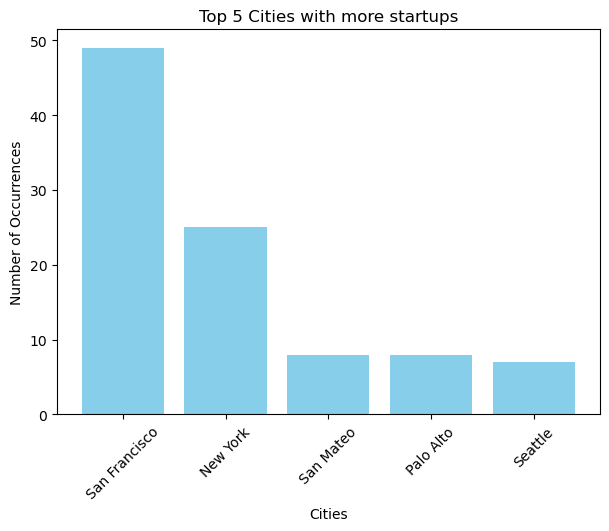

In [5]:
city_counts = df_startups['City'].value_counts()

top_cities = city_counts.head(5)

cities = top_cities.index
counts = top_cities.values

plt.figure(figsize=(7, 5))
plt.bar(cities, counts, color='skyblue')
plt.xlabel('Cities')
plt.ylabel('Number of Occurrences')
plt.title('Top 5 Cities with more startups')
plt.xticks(rotation=45)  
plt.savefig('../img/top_cities_startups.png', bbox_inches='tight', dpi=300)
plt.show()

### Design companies

In [6]:
def search_design_companies(country_code):

    pipeline = [
        {
            "$match": {
                "offices.country_code": country_code,
                "category_code": {"$in":["games_video","ecommerce","software","social","messaging","web"]}
            }
        },
        {
            "$unwind": "$funding_rounds"
        },
        {
            "$group": {
                "_id": "$_id",
                "name": {"$first": "$name"},
                "offices": {"$first": "$offices"}
            }
        },
        {
            "$project": {
                "_id": 0,
                "Name": "$name",
                "City": {"$arrayElemAt": ["$offices.city", 0]},
                "Location": {
                    "type": "Point",
                    "coordinates": [
                        {"$arrayElemAt": ["$offices.longitude", 0]},
                        {"$arrayElemAt": ["$offices.latitude", 0]}
                    ]
                },
            }
        },
        {
            "$out": "design_companies"
        }
    ]

    c.aggregate(pipeline)

    design_companies = db.get_collection("design_companies")
    cursor = design_companies.find(projection={"_id":0})

    df = pd.DataFrame(list(cursor))
    df.to_csv("../data/design_companies.csv")
    
    return df

In [7]:

df_design = search_design_companies("USA")
df_design


,Name,City,Location
0,Spoke,San Mateo,"{'type': 'Point', 'coordinates': [-122.302262,..."
1,Taaz,San Diego,"{'type': 'Point', 'coordinates': [-117.211102,..."
2,Cherwell Software,Colorado Springs,"{'type': 'Point', 'coordinates': [-104.81628, ..."
3,Labmeeting,,"{'type': 'Point', 'coordinates': [-119.306607,..."
4,Funji,San Francisco,"{'type': 'Point', 'coordinates': [None, None]}"
...,...,...,...
1763,KnowledgeTree,Raleigh,"{'type': 'Point', 'coordinates': [-78.647003, ..."
1764,Tesaris,Herriman,"{'type': 'Point', 'coordinates': [-112.032503,..."
1765,Nexway,Nanterre cedex,"{'type': 'Point', 'coordinates': [2.2200007, 4..."
1766,Corrigo,Tualatin,"{'type': 'Point', 'coordinates': [None, None]}"


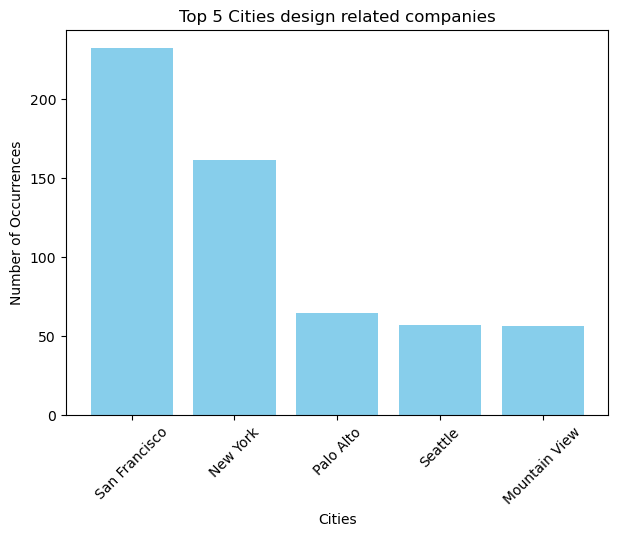

In [8]:
city_counts = df_design['City'].value_counts()

top_cities = city_counts.head(5)

cities = top_cities.index
counts = top_cities.values

plt.figure(figsize=(7, 5))
plt.bar(cities, counts, color='skyblue')
plt.xlabel('Cities')
plt.ylabel('Number of Occurrences')
plt.title('Top 5 Cities design related companies')
plt.xticks(rotation=45)  
plt.savefig('../img/top_cities_design_companies.png', bbox_inches='tight', dpi=300)
plt.show()